## 1. Quá trình dự báo trên mô hình ARIMA

# Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

# Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('xrp.csv')
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Open')

df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",inplace=True)
df_close = df['Close'].values.reshape(-1, 1)

df

,Close
Date,
2020-06-01,0.21090
2020-06-02,0.20317
2020-06-03,0.20411
2020-06-04,0.20438
2020-06-05,0.20282
...,...
2022-05-28,0.38637
2022-05-29,0.38910
2022-05-30,0.41859


# Chuẩn hóa dữ liệu

In [3]:
arima_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Close'] = arima_sc.fit_transform(df_close)
df_scaled

,Close
Date,
2020-06-01,-1.244092
2020-06-02,-1.265447
2020-06-03,-1.262850
2020-06-04,-1.262104
2020-06-05,-1.266414
...,...
2022-05-28,-0.759352
2022-05-29,-0.751810
2022-05-30,-0.670343


# Vẽ đồ thị

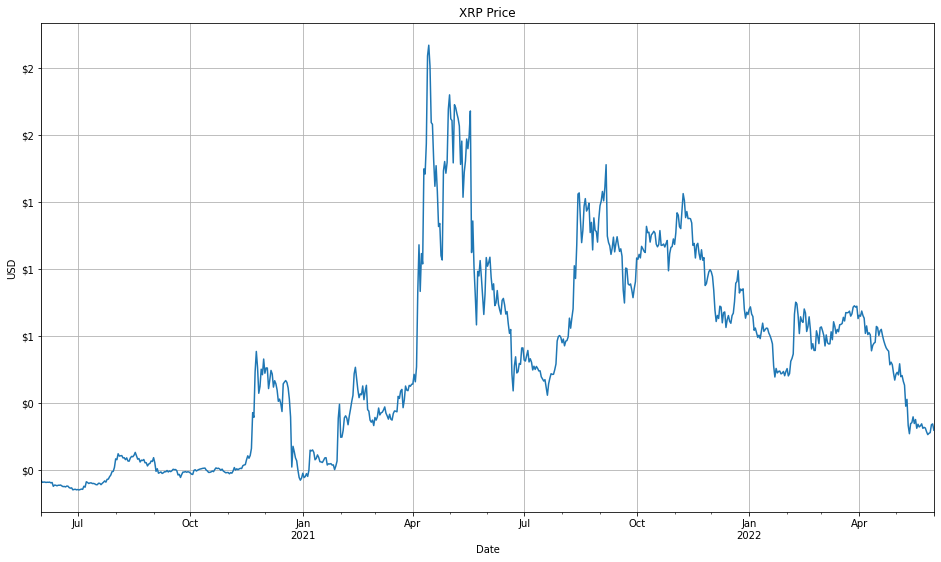

In [4]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'XRP Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Tách dữ liệu thành tập train và test

In [5]:
train, test = df_scaled[:(int)(len(df_scaled) * 0.7)], df_scaled[(int)(len(df_scaled) * 0.7):]
index_test = df_scaled.index[(int)(len(df_scaled) * 0.7):]
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (511, 1)
test shape:  (220, 1)


# Hàm kiểm định chuỗi dừng

In [6]:
def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

# Kiểm định tính dừng của chuỗi

In [7]:
adf_test(train['Close'],'XRP Price')

Augmented Dickey-Fuller Test: XRP Price
ADF test statistic         -1.853685
p-value                     0.354153
Number of lags used        18.000000
Number of observations    492.000000
critical value (1%)        -3.443711
critical value (5%)        -2.867432
critical value (10%)       -2.569908
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

# Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

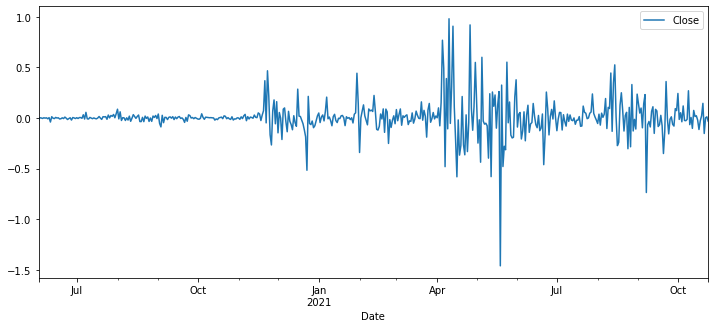

In [8]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

# Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [9]:
adf_test(diff_1, 'XRP Price First Difference')

Augmented Dickey-Fuller Test: XRP Price First Difference
ADF test statistic         -4.859361
p-value                     0.000042
Number of lags used        18.000000
Number of observations    491.000000
critical value (1%)        -3.443739
critical value (5%)        -2.867444
critical value (10%)       -2.569915
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [10]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [11]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-332.654, Time=1.42 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-333.401, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-333.664, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-333.615, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-335.025, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-331.682, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.447 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  511
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 168.513
Date:                Sat, 25 Jun 2022   AIC                           -335.025
Time:                        18:07:31   BIC                           -330.791
Sample:                             0   HQIC                          -333.365
                                - 511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0302      0.001     48.219      0.000       0.029       0.031
===================================================================================
Ljung-Box (L1) (Q):                   2.28   Jarque-Bera (JB):              5639.55
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):             101.11   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Dự đoán trên tập test

In [12]:
pred = arima_model.predict(len(test))
pred


array([1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331272,
       1.16331272, 1.16331272, 1.16331272, 1.16331272, 1.16331

# Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [13]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

# Vẽ đồ thị cho tập test và kết quả dự đoán

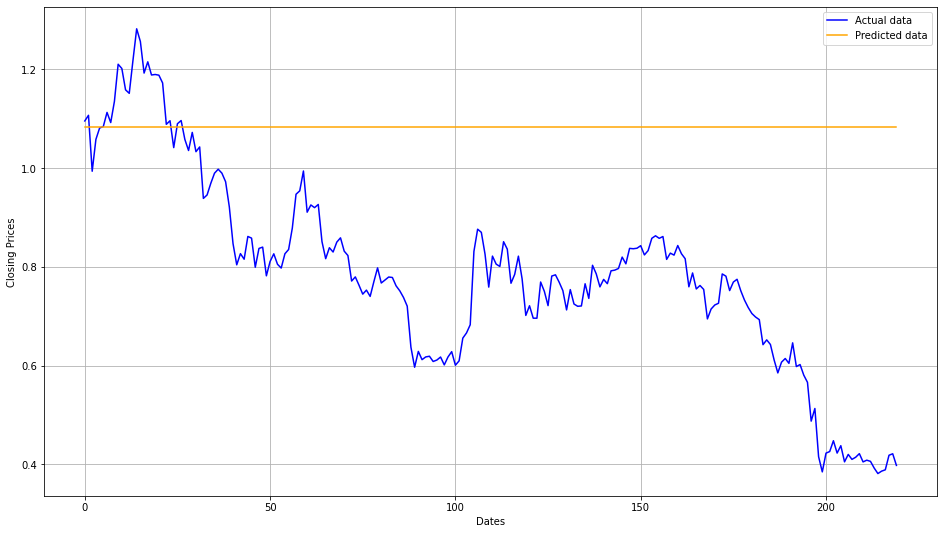

In [14]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [15]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.31
MAPE: 49.91%
MSE: 0.13
RMSE: 0.36
R2: -2.24


# Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [16]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2021-10-25,1.09527,1.08235,0.01292
2021-10-26,1.10674,1.08235,0.02439
2021-10-27,0.99349,1.08235,-0.08886
2021-10-28,1.05793,1.08235,-0.02442
2021-10-29,1.08098,1.08235,-0.00137
...,...,...,...
2022-05-28,0.38637,1.08235,-0.69598
2022-05-29,0.38910,1.08235,-0.69325
2022-05-30,0.41859,1.08235,-0.66376


## 2. Quá trình dự đoán trên mô hình LSTM

# Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [17]:
df_lstm = df_pred.copy()
df_lstm

,Actual,ARIMA,Error
Date,,,
2021-10-25,1.09527,1.08235,0.01292
2021-10-26,1.10674,1.08235,0.02439
2021-10-27,0.99349,1.08235,-0.08886
2021-10-28,1.05793,1.08235,-0.02442
2021-10-29,1.08098,1.08235,-0.00137
...,...,...,...
2022-05-28,0.38637,1.08235,-0.69598
2022-05-29,0.38910,1.08235,-0.69325
2022-05-30,0.41859,1.08235,-0.66376


# Vẽ đồ thị thể hiện sai số

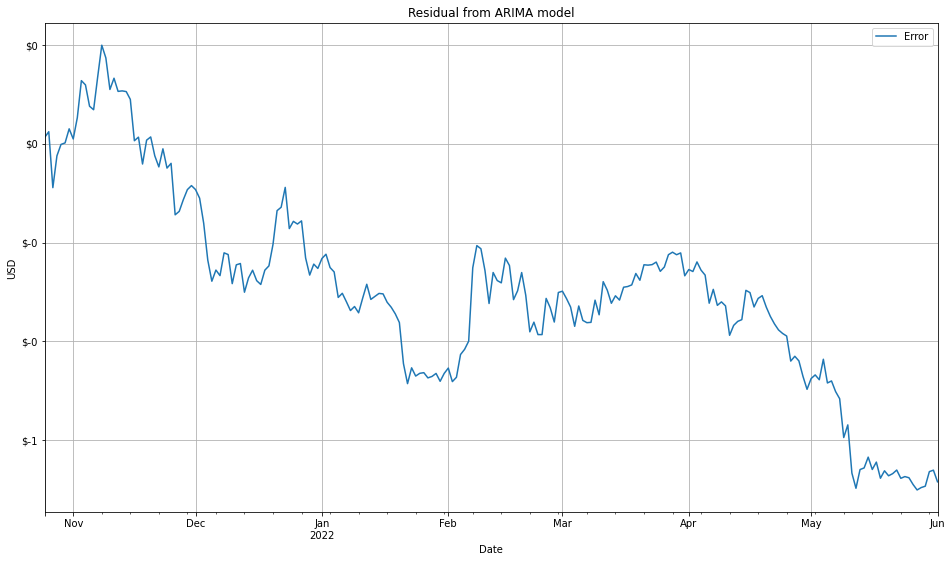

In [18]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [19]:
error = np.array(error)
error

array([[ 0.01292],
       [ 0.02439],
       [-0.08886],
       [-0.02442],
       [-0.00137],
       [ 0.00171],
       [ 0.03022],
       [ 0.0097 ],
       [ 0.05278],
       [ 0.12775],
       [ 0.11912],
       [ 0.07596],
       [ 0.06885],
       [ 0.13555],
       [ 0.1995 ],
       [ 0.17373],
       [ 0.10988],
       [ 0.13264],
       [ 0.10601],
       [ 0.10702],
       [ 0.10557],
       [ 0.08986],
       [ 0.00616],
       [ 0.01335],
       [-0.04102],
       [ 0.00728],
       [ 0.01379],
       [-0.02436],
       [-0.04687],
       [-0.01026],
       [-0.04925],
       [-0.03968],
       [-0.14381],
       [-0.13688],
       [-0.11332],
       [-0.09285],
       [-0.08474],
       [-0.09277],
       [-0.11018],
       [-0.161  ],
       [-0.23538],
       [-0.27829],
       [-0.25567],
       [-0.26697],
       [-0.22087],
       [-0.22426],
       [-0.28319],
       [-0.24513],
       [-0.24245],
       [-0.30055],
       [-0.27156],
       [-0.25603],
       [-0.2

In [20]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (217, 3, 1)
y_train (217, 1)


In [21]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("xrp_7_3.h5")

Epoch 1/300
7/7 [==============================] - 4s 6ms/step - loss: 0.1236
Epoch 2/300
7/7 [==============================] - 0s 7ms/step - loss: 0.1073
Epoch 3/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0913
Epoch 4/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0741
Epoch 5/300
7/7 [==============================] - 0s 6ms/step - loss: 0.0537
Epoch 6/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0330
Epoch 7/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0152
Epoch 8/300
7/7 [==============================] - 0s 8ms/step - loss: 0.0072
Epoch 9/300
7/7 [==============================] - 0s 10ms/step - loss: 0.0033
Epoch 10/300
7/7 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 11/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0026
Epoch 12/300
7/7 [==============================] - 0s 7ms/step - loss: 0.0024
Epoch 13/300
7/7 [==============================] - 0s 7ms/s

In [22]:
model = load_model("xrp_7_3.h5")
error_pred = model.predict(x_train)
error_pred

7/7 [==============================] - 1s 8ms/step


array([[-0.05074341],
       [-0.03459074],
       [-0.00500893],
       [-0.00189172],
       [ 0.022824  ],
       [ 0.0178487 ],
       [ 0.04389383],
       [ 0.1026554 ],
       [ 0.1146457 ],
       [ 0.08734183],
       [ 0.07330659],
       [ 0.1105081 ],
       [ 0.15003976],
       [ 0.14265071],
       [ 0.11430021],
       [ 0.11464196],
       [ 0.10702758],
       [ 0.10168472],
       [ 0.10128953],
       [ 0.09210552],
       [ 0.04276309],
       [ 0.01590846],
       [-0.02638919],
       [-0.00937831],
       [ 0.01022968],
       [-0.01344955],
       [-0.04484427],
       [-0.02848462],
       [-0.04546618],
       [-0.05154461],
       [-0.12980148],
       [-0.14874226],
       [-0.13109691],
       [-0.10575338],
       [-0.09584798],
       [-0.10344437],
       [-0.12317476],
       [-0.17177528],
       [-0.2345524 ],
       [-0.27871218],
       [-0.26118782],
       [-0.27202868],
       [-0.22866122],
       [-0.23307513],
       [-0.2851252 ],
       [-0

In [23]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2021-10-25,1.09527,1.08235,0.01292,-0.050743
2021-10-26,1.10674,1.08235,0.02439,-0.034591
2021-10-27,0.99349,1.08235,-0.08886,-0.005009
2021-10-28,1.05793,1.08235,-0.02442,-0.001892
2021-10-29,1.08098,1.08235,-0.00137,0.022824
...,...,...,...,...
2022-05-25,0.40620,1.08235,-0.67615,-0.697738
2022-05-26,0.39265,1.08235,-0.68970,-0.697423
2022-05-27,0.38149,1.08235,-0.70086,-0.696503


In [24]:
df_lstm['ARIMA_LSTM'] = df_lstm['ARIMA'] + df_lstm['Error Prediction']
df_lstm

,Actual,ARIMA,Error,Error Prediction,ARIMA_LSTM
Date,,,,,
2021-10-25,1.09527,1.08235,0.01292,-0.050743,1.031607
2021-10-26,1.10674,1.08235,0.02439,-0.034591,1.047759
2021-10-27,0.99349,1.08235,-0.08886,-0.005009,1.077341
2021-10-28,1.05793,1.08235,-0.02442,-0.001892,1.080458
2021-10-29,1.08098,1.08235,-0.00137,0.022824,1.105174
...,...,...,...,...,...
2022-05-25,0.40620,1.08235,-0.67615,-0.697738,0.384612
2022-05-26,0.39265,1.08235,-0.68970,-0.697423,0.384927
2022-05-27,0.38149,1.08235,-0.70086,-0.696503,0.385847


# Vẽ đồ thị

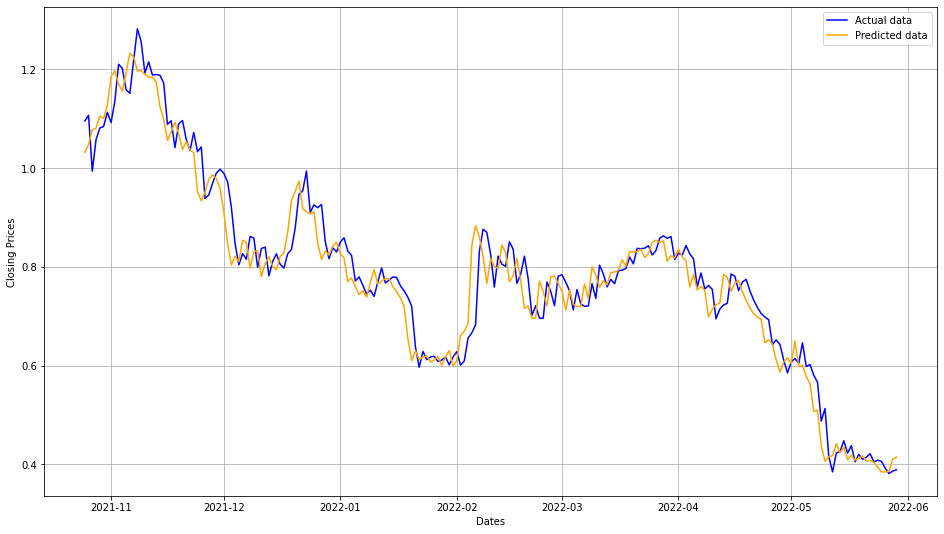

In [25]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['ARIMA_LSTM'], 'orange', label='Predicted data')
plt.legend()

# Đánh giá mô hình

In [26]:
mae = mean_absolute_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.ARIMA_LSTM)
rmse = np.sqrt(mse)
r2 = r2_score(df_lstm.Actual, df_lstm.ARIMA_LSTM)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.03
MAPE: 4.36%
MSE: 0.00
RMSE: 0.05
R2: 0.94


# Lấy 3 ngày cuối ra để dự báo

In [27]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -0.70086
2022-05-28   -0.69598
2022-05-29   -0.69325
Name: Error, dtype: float64

# Đưa về ma trận

In [28]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-0.70086],
        [-0.69598],
        [-0.69325]]])

In [29]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 33ms/step


array([-0.69650316], dtype=float32)

# So sánh kết quả dự đoán với giá trị thực

In [30]:
y_arima = df_pred.copy()
y_arima = y_arima.tail(4).head(1)
y_arima

,Actual,ARIMA,Error
Date,,,
2022-05-29,0.3891,1.08235,-0.69325


In [31]:
y_arima['Final_LSTM'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_LSTM
Date,,,,
2022-05-29,0.3891,1.08235,-0.69325,0.385847


# Ghi ra file csv

In [32]:
df.to_csv("xrp_processed_data_7_3.csv")
df_scaled.to_csv("xrp_scaled_data_7_3.csv")
df_pred.to_csv("xrp_ARIMA-PRED_7_3.csv")
df_lstm.to_csv("xrp_LSTM_PRED_7_3.csv")
y_arima.to_csv("xrp_Forecast_7_3.csv")